In [ ]:
import os, sys,shutil, gc

from glob import glob
from tqdm import tqdm

import math
import random
from collections import OrderedDict
import warnings

import albumentations as A
import cv2
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import timm
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW,lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import fbeta_score, average_precision_score, roc_auc_score

import multiprocessing

from einops import rearrange, reduce, repeat
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.decoders.unet.decoder import UnetDecoder
from timm.models.resnet import resnet34d, seresnext26t_32x4d

from ink_helpers import (load_image,seed_everything,
                         load_fragment, DiceLoss, FocalLoss, dice_bce_loss)

warnings.simplefilter("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
print("cpu count:", multiprocessing.cpu_count())

cuda
cpu count: 32


In [ ]:
# Config:
random_seed = 42
num_workers = min(12, multiprocessing.cpu_count())

bottom_channel_idx = 17
top_channel_idx = 29
num_fluctuate_channel = 1

num_select_channel = top_channel_idx - bottom_channel_idx

block_size = 256
stride = 128
kernel_size = 61

loss_type = ['bce', 'focal', 'bcedice'][2]
max_lr = 5.0e-5
weight_decay = 1.0e-3
total_epoch = 10
batch_size = 32

valid_id = '2c'

seed_everything(seed=random_seed)

In [ ]:
all_frag_ids = ['1', '2a', '2b', '2c', '3']
id2dir = {id:f'./frags/train_{id}' for id in all_frag_ids}
train_id_list = [id for id in all_frag_ids if id != valid_id]
print('Train:', train_id_list)

Train: ['1', '2a', '2b', '3']


In [ ]:
id2images,id2frag_mask,id2ink_mask = {},{},{}
for frag_id in tqdm(all_frag_ids):
    _,frag_mask,ink_mask = load_fragment(frag_id)
    id2images[frag_id] = np.load(f'{id2dir[frag_id]}/landscape_peel_surface_kernel{kernel_size}_top15_bottom20.npy')
    id2frag_mask[frag_id] = frag_mask
    id2ink_mask[frag_id] = ink_mask

100%|█████████████████████████████████████████████| 5/5 [01:14<00:00, 14.99s/it]


In [ ]:
class InkDataSet2D(Dataset):
    '''
    image: (D, H, W); mask: (1, H, W)
    '''
    def __init__(self, frag_id_list, block_size, channel_slip=0, transforms=None, has_label=True):
        self.frag_id_list = frag_id_list
        self.block_size = block_size
        self.transforms = transforms
        self.has_label = has_label
        
        # get xy positions
        id_xybt_list = []
        for frag_id in frag_id_list:
            frag_mask = id2frag_mask[frag_id]
            xy_pairs = [
                (min(x,frag_mask.shape[1]-block_size), min(y,frag_mask.shape[0]-block_size))
                for x in range(0, frag_mask.shape[1]-block_size+stride, stride) 
                for y in range(0, frag_mask.shape[0]-block_size+stride, stride) 
                if np.any(frag_mask[y:y+block_size, x:x+block_size] > 0)
            ]
            bt_pairs = [(bottom_channel_idx+f, top_channel_idx+f)
                        for f in range(-channel_slip, channel_slip+1)]
            id_xybt_list += [(frag_id, *xy, *bt) for xy in xy_pairs for bt in bt_pairs]
        self.id_xybt_list = id_xybt_list
        
    def __len__(self):
        return len(self.id_xybt_list)

    def __getitem__(self, idx):
        frag_id,x,y,start_z,end_z = self.id_xybt_list[idx]

        whole_image = id2images[frag_id]
        image = whole_image[start_z:end_z, 
                            y:y+self.block_size, 
                            x:x+self.block_size] # D,H,W
        image = np.moveaxis(image, 0, 2) # H,W,D

        if self.has_label:
            whole_mask = id2ink_mask[frag_id]
            mask = whole_mask[y:y+self.block_size, 
                              x:x+self.block_size] # H,W
            
            if self.transforms:
                transformed = self.transforms(image=image, mask=mask)
                image, mask = transformed['image'], transformed['mask']
                
            image = np.moveaxis(image, 2, 0) # D,H,W
            mask = np.expand_dims(mask, 0) # 1,H,W
            
            return idx, image, mask
        else:
            if self.transforms:
                image = self.transforms(image=image)['image']
            image = np.moveaxis(image, 2, 0) # D,H,W
            return idx,image

In [ ]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=1.0),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5)
        ], p=1),
        A.CoarseDropout(max_holes=1, max_width=int(block_size * 0.3), max_height=int(block_size * 0.3), 
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0]*num_select_channel, 
            std=[1]*num_select_channel
        ),
    ]
)

train_dataset = InkDataSet2D(
    frag_id_list=train_id_list, 
    block_size=block_size, 
    channel_slip=num_fluctuate_channel, 
    transforms=train_transform, 
    has_label=True
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    prefetch_factor=1,
)

valid_transform = A.Compose([
        A.Normalize(
            mean=[0]*num_select_channel, 
            std=[1]*num_select_channel
        ),
    ]
)

valid_dataset = InkDataSet2D(
    frag_id_list=[valid_id], 
    block_size=block_size, 
    channel_slip=0, 
    transforms=valid_transform, 
    has_label=False
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    prefetch_factor=1,
)

print('Train', len(train_dataloader), ', Valid', len(valid_dataloader), )

Train 749 , Valid 66


# Model

In [ ]:
model_name = ['UNet', 'UNetPlusPlus','MAnet'][1]
backbone_name = ['resnet34', 'timm-resnest26d', 'xception'][2]

In [ ]:
if model_name == 'UNet':
    model = smp.Unet(
        encoder_name=backbone_name,      
        encoder_weights=None,     
        in_channels=num_select_channel,                  
        classes=1,        
        activation=None,
    );
elif model_name == 'UNetPlusPlus':
    model = smp.UnetPlusPlus(
        encoder_name=backbone_name,      
        encoder_weights=None,     
        in_channels=num_select_channel,                  
        classes=1,        
        activation=None,
    );
elif model_name == 'MAnet':
    model = smp.MAnet(
        encoder_name=backbone_name,      
        encoder_weights=None,     
        in_channels=num_select_channel,                  
        classes=1,        
        activation=None,
    );
    
model.to(device);

In [ ]:
# a = torch.from_numpy( np.random.choice(256, (1, 12, 256, 256))).float().cuda()
    
# with torch.no_grad():
#     with torch.cuda.amp.autocast(enabled=True):
#         output = model(a)

In [ ]:
if loss_type == 'bce':
    criterion = nn.BCEWithLogitsLoss()
elif loss_type == 'focal':
    criterion = FocalLoss(alpha=1, gamma=2, use_logits=True)
if loss_type == 'bcedice':
    criterion = dice_bce_loss
    
    
optimizer = AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    epochs=total_epoch,
    steps_per_epoch=len(train_dataloader),
    max_lr=max_lr,
    pct_start=0.1,
    anneal_strategy="cos",
    div_factor=1.0e3,
    final_div_factor=1.0e1,
)
scaler = GradScaler()
Sig = nn.Sigmoid()

loss_list = [1] * 10
for epoch in range(total_epoch):
    
    # training
    gc.collect()
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader)) as pbar:
        for step, (idx, img, target) in pbar:
            
            img, target = img.to(device).float(), target.to(device).float()
            
            optimizer.zero_grad()
            with autocast():
                outputs = model(img).float()
            loss = criterion(outputs, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            pbar.set_description(f"Ep{epoch:02d}")
            loss_list = loss_list[1:] + [loss.item()]
            pbar.set_postfix(
                OrderedDict(
                    LR=f"{scheduler.get_last_lr()[0]:.1e}",
                    Loss=f"{sum(loss_list)/10:.3f}",
                )
            )
            
            
    
    # validation
    if not len(valid_dataloader):
        continue
    valid_frag_mask = id2frag_mask[valid_id]
    valid_ink_mask = id2ink_mask[valid_id]
    valid_ink_predicts = np.zeros(valid_frag_mask.shape).astype(float)
    valid_ink_count = np.zeros(valid_frag_mask.shape)
    valid_xybt_list = valid_dataset.id_xybt_list
    
    model.eval()
    for idx, img in tqdm(valid_dataloader):
        img = img.to(device).float()
        with torch.no_grad():
            with autocast():
                outputs = Sig(model(img).float())

        for batch_idx,whole_idx in enumerate(idx):
            x,y = map(int, valid_xybt_list[whole_idx][1:3])

            valid_ink_predicts[y:y+block_size, x:x+block_size] += outputs.cpu()[batch_idx][0].numpy()
            valid_ink_count[y:y+block_size, x:x+block_size] += 1
    
    valid_ink_count[np.where(valid_frag_mask==0)] = 1
    valid_ink_predicts = valid_ink_predicts/valid_ink_count
    valid_ink_predicts[np.where(valid_frag_mask==0)] = 0

    valid_ink_predicts_flat = valid_ink_predicts[np.where(valid_frag_mask)].flatten()
    valid_ink_mask_flat = valid_ink_mask[np.where(valid_frag_mask)].flatten()

    map_score = average_precision_score(valid_ink_mask_flat, valid_ink_predicts_flat)
    auc_score = roc_auc_score(valid_ink_mask_flat, valid_ink_predicts_flat)
    fhalf_score = fbeta_score(valid_ink_mask_flat, valid_ink_predicts_flat>0.5, beta=0.5)
    print(f'Valid: mAP {map_score:.2f}, AUC {auc_score:.2f}, F0.5 {fhalf_score:.2f}, ')
    model.train()
    
# save weights
torch.save(
    model.state_dict(), 
    f'./weights/Surface{kernel_size}-SMP-{model_name}-{backbone_name}-block{block_size}-channel{bottom_channel_idx}-to{top_channel_idx}'
    f'-slip{num_fluctuate_channel}-loss{loss_type}-lr{max_lr}-wd{weight_decay}-bs{batch_size}'
    f'-valid{valid_id}-step{total_epoch*len(train_dataloader)}-seed{random_seed}-epoch{total_epoch}.pth'
)
    
gc.collect()

100%|███████████████████████████████████████████| 66/66 [00:09<00:00,  6.79it/s]


Valid: mAP 0.30, AUC 0.66, F0.5 0.30, 


100%|███████████████████████████████████████████| 66/66 [00:09<00:00,  6.80it/s]


Valid: mAP 0.41, AUC 0.73, F0.5 0.40, 


100%|███████████████████████████████████████████| 66/66 [00:09<00:00,  6.74it/s]


Valid: mAP 0.47, AUC 0.77, F0.5 0.50, 


100%|███████████████████████████████████████████| 66/66 [00:09<00:00,  6.78it/s]


Valid: mAP 0.49, AUC 0.77, F0.5 0.47, 


100%|███████████████████████████████████████████| 66/66 [00:09<00:00,  6.75it/s]


Valid: mAP 0.54, AUC 0.81, F0.5 0.52, 


100%|███████████████████████████████████████████| 66/66 [00:09<00:00,  6.75it/s]


Valid: mAP 0.54, AUC 0.81, F0.5 0.55, 


100%|███████████████████████████████████████████| 66/66 [00:09<00:00,  6.74it/s]


Valid: mAP 0.57, AUC 0.82, F0.5 0.55, 


100%|███████████████████████████████████████████| 66/66 [00:09<00:00,  6.81it/s]


Valid: mAP 0.57, AUC 0.82, F0.5 0.57, 


100%|███████████████████████████████████████████| 66/66 [00:09<00:00,  6.78it/s]


Valid: mAP 0.59, AUC 0.83, F0.5 0.58, 


100%|███████████████████████████████████████████| 66/66 [00:09<00:00,  6.72it/s]


Valid: mAP 0.59, AUC 0.83, F0.5 0.59, 


0

In [ ]:
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    print(i, fbeta_score(valid_ink_mask_flat, valid_ink_predicts_flat>i, beta=0.5))

0.1 0.38719174501295134
0.2 0.47012740101069017
0.3 0.5244496216038732
0.4 0.5654651159380945
0.5 0.5936878481565461
0.6 0.6000543772896061


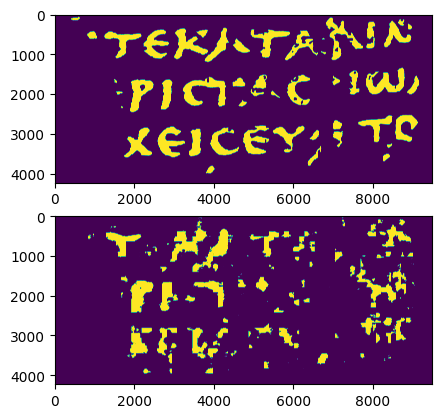

In [ ]:
plt.subplot(2, 1, 1)
plt.imshow(valid_ink_mask)
plt.subplot(2, 1, 2)
plt.imshow(valid_ink_predicts>0.5)

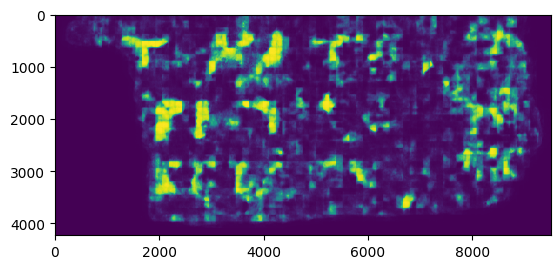

In [ ]:
plt.imshow(valid_ink_predicts)